In [1]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [4]:
tx_data = pd.read_csv('E:\Milad\data.csv')

In [5]:
tx_data.shape

(233048, 9)

In [6]:
tx_data.head(10)

,user_id,order_id,order_date,days_to_next_order,order_value,avg_order_value,avg_order_value_last7,average_frequency_last7,average_frequency
0,5088253,6d9fd50d354a5fe90e1ed8db9a0638e0,2020-10-01,5,794,693,677,68.1429,59.6250
1,5088253,1a33f8f8a8fd22fc2f339eeb16b0ce9b,2020-10-06,1,101,627,611,3.4286,53.5556
2,5088253,cc955fe2ca7330f90f9eb091a4ee3537,2020-10-07,1,714,636,634,3.2857,48.3000
3,5088253,2ad1075b6ec0850b23a09fba5683fad8,2020-10-08,5,913,661,664,3.0000,44.0000
4,5088253,4da745f11257f8d4c00f49cefca7a7cd,2020-10-13,0,1137,701,684,2.8571,34.9286
5,5088253,b3b2b05d665e2c7c7b68015877ea4f2c,2020-10-13,0,837,711,609,2.5714,37.6154
6,5088253,2cb3b6b8a149e099fc4e4118626efa2c,2020-10-13,4,290,681,613,2.4286,40.7500
7,5088253,840d3bf03be97deab407885724beaa3e,2020-10-17,3,1210,716,743,2.2857,32.8667
8,5088253,ca6a29932fa14101ea36e0855a3e9dcd,2020-10-20,0,380,695,783,2.0000,31.0000
9,5088253,ab75f86d2dda1f4ea6a86c97028b5e1a,2020-10-20,3,871,706,805,1.8571,29.1765


In [8]:
tx_data['order_date'] = pd.to_datetime(tx_data['order_date'])

In [9]:
tx_data['order_date'].describe()

count                  233048
unique                   2237
top       2021-02-25 00:00:00
freq                      485
first     2014-11-11 00:00:00
last      2021-03-06 00:00:00
Name: order_date, dtype: object

In [7]:
tx_data.order_date

0         2020-10-01
1         2020-10-06
2         2020-10-07
3         2020-10-08
4         2020-10-13
             ...    
233043    2021-02-09
233044    2021-02-16
233045    2021-02-18
233046    2021-02-25
233047    2021-02-25
Name: order_date, Length: 233048, dtype: object

In [10]:
tx_6y = tx_data[(tx_data.order_date < date(2020,9,1)) & (tx_data.order_date >= date(2014,11,11))].reset_index(drop=True)
tx_next = tx_data[(tx_data.order_date >= date(2020,9,1)) & (tx_data.order_date < date(2021,3,6))].reset_index(drop=True)

In [11]:
tx_next['order_date'].describe()

count                   66754
unique                    186
top       2021-02-25 00:00:00
freq                      485
first     2020-09-01 00:00:00
last      2021-03-05 00:00:00
Name: order_date, dtype: object

In [12]:
tx_user = pd.DataFrame(tx_6y['user_id'].unique())
tx_user.columns = ['user_id']

# Adding label

In [13]:
tx_next_first_purchase = tx_next.groupby('user_id').order_date.min().reset_index()

In [14]:
tx_next_first_purchase.columns = ['user_id','MinPurchaseDate']

In [15]:
tx_next_first_purchase.head()

,user_id,MinPurchaseDate
0,1899901,2020-09-01
1,1960755,2020-09-02
2,2169787,2020-09-01
3,2173281,2020-09-01
4,2327549,2020-09-03


In [16]:
tx_last_purchase = tx_6y.groupby('user_id').order_date.max().reset_index()

In [17]:
tx_last_purchase.columns = ['user_id','MaxPurchaseDate']

In [18]:
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='user_id',how='left')

In [19]:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days



In [20]:
tx_purchase_dates.head()

,user_id,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,1899901,2020-08-31,2020-09-01,1
1,1960755,2020-08-29,2020-09-02,4
2,2169787,2020-08-26,2020-09-01,6
3,2173281,2020-08-31,2020-09-01,1
4,2327549,2020-08-30,2020-09-03,4


In [21]:
tx_user = pd.merge(tx_user, tx_purchase_dates[['user_id','NextPurchaseDay']],on='user_id',how='left')

In [22]:
tx_user.head()

,user_id,NextPurchaseDay
0,5861481,30
1,4113453,36
2,4357445,3
3,5889917,6
4,5714669,70


In [23]:
tx_user.shape

(1211, 2)

In [27]:
#tx_user.isna().sum()
#tx_user = tx_user.fillna(999)

user_id            0
NextPurchaseDay    0
dtype: int64

# Recency

In [24]:
tx_max_purchase = tx_6y.groupby('user_id').order_date.max().reset_index()

In [25]:
tx_max_purchase.columns = ['user_id','MaxPurchaseDate']

In [26]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [27]:
tx_user = pd.merge(tx_user, tx_max_purchase[['user_id','Recency']], on='user_id')

In [28]:
tx_user.head()

,user_id,NextPurchaseDay,Recency
0,5861481,30,24
1,4113453,36,27
2,4357445,3,1
3,5889917,6,2
4,5714669,70,44


In [29]:
tx_user.Recency.describe()

count    1211.000000
mean       13.173410
std        54.564524
min         0.000000
25%         1.000000
50%         3.000000
75%         8.000000
max      1065.000000
Name: Recency, dtype: float64

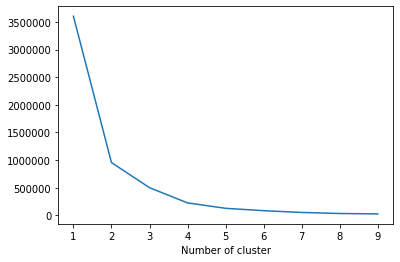

In [30]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [31]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [32]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [33]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [34]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,3.0,896.000000,146.365980,810.0,811.50,813.0,939.0,1065.0
1,3.0,455.333333,60.451082,402.0,422.50,443.0,482.0,521.0
2,48.0,103.479167,43.046234,56.0,67.75,98.5,122.5,207.0
3,1157.0,5.991357,8.798096,0.0,1.00,3.0,7.0,53.0


# Frequency

In [36]:
tx_frequency = tx_6y.groupby('user_id').order_date.count().reset_index()

In [37]:
tx_frequency.columns = ['user_id','Frequency']

In [38]:
tx_frequency.head()

,user_id,Frequency
0,1899901,521
1,1960755,430
2,2169787,158
3,2173281,79
4,2327549,379


In [39]:
tx_user = pd.merge(tx_user, tx_frequency, on='user_id')

In [40]:
tx_user.head()

,user_id,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,5861481,30,24,3,2
1,4113453,36,27,3,67
2,4357445,3,1,3,88
3,5889917,6,2,3,38
4,5714669,70,44,3,2


In [41]:
tx_user.Frequency.describe()

count    1211.000000
mean      137.317093
std       163.095516
min         1.000000
25%        34.000000
50%        88.000000
75%       187.500000
max      2551.000000
Name: Frequency, dtype: float64

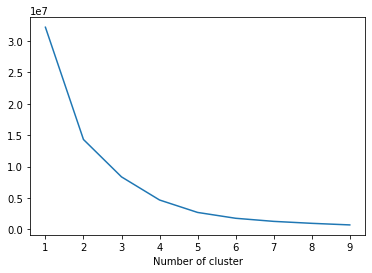

In [42]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [43]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [44]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,335.0,230.397015,64.626152,144.0,177.00,217.0,272.0,396.0
1,801.0,55.936330,39.294461,1.0,22.00,48.0,87.0,142.0
2,1.0,2551.000000,NaN,2551.0,2551.00,2551.0,2551.0,2551.0
3,74.0,564.216216,167.039104,401.0,438.25,496.0,655.0,1172.0


In [45]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Revenue

In [46]:
tx_revenue = tx_6y.groupby('user_id').order_value.sum().reset_index()

In [47]:
tx_revenue.head()

,user_id,order_value
0,1899901,360466
1,1960755,189576
2,2169787,194054
3,2173281,77857
4,2327549,284140


In [48]:
tx_user = pd.merge(tx_user, tx_revenue, on='user_id')

In [49]:
tx_user.order_value.describe()

count    1.211000e+03
mean     1.902568e+05
std      2.869937e+05
min      4.070000e+02
25%      4.270250e+04
50%      1.072010e+05
75%      2.576620e+05
max      5.254312e+06
Name: order_value, dtype: float64

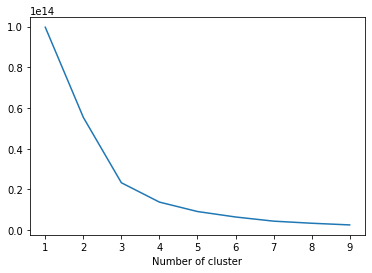

In [50]:
sse={}
tx_revenue = tx_user[['order_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [51]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['order_value']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['order_value']])

In [52]:
tx_user = order_cluster('RevenueCluster', 'order_value',tx_user,True)

In [53]:
tx_user.groupby('RevenueCluster')['order_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,805.0,6.993538e+04,5.104773e+04,407.0,25883.00,58121.0,106434.00,185663.0
1,312.0,3.022080e+05,7.936619e+04,186286.0,240279.25,282663.5,358501.25,503639.0
2,90.0,7.309258e+05,2.302233e+05,517888.0,575476.50,657117.0,793107.25,1733222.0
3,4.0,3.507700e+06,1.290411e+06,2327950.0,2668000.75,3224269.0,4063968.25,5254312.0


# Overall Segmentation

In [54]:
tx_user.head()

,user_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,order_value,RevenueCluster
0,5861481,30,24,3,2,0,1438,0
1,4113453,36,27,3,67,0,65116,0
2,4357445,3,1,3,88,0,83900,0
3,5889917,6,2,3,38,0,29965,0
4,5714669,70,44,3,2,0,513,0


In [55]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [56]:
tx_user.groupby('OverallScore')['Recency','Frequency','order_value'].mean()

,Recency,Frequency,order_value
OverallScore,,,
0,896.000000,10.333333,1.000700e+04
1,455.333333,6.333333,7.185000e+03
2,105.727273,26.000000,3.215227e+04
3,7.905386,53.516739,6.621387e+04
4,5.073529,147.220588,1.949689e+05
5,3.800905,232.723982,3.083818e+05
6,3.169231,371.307692,5.554470e+05
7,1.541667,569.041667,8.050580e+05
8,2.000000,959.000000,2.925496e+06


In [57]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0      3
1      3
2     44
3    687
4    136
5    221
6     65
7     48
8      3
9      1
Name: Recency, dtype: int64

In [58]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']==2,'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']==6,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']==7,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']==3,'Segment'] = 'High-Value'
tx_user.loc[tx_user['OverallScore']==4,'Segment'] = 'High-Value' 
tx_user.loc[tx_user['OverallScore']==5,'Segment'] = 'High-Value' 

In [59]:
tx_user.head()

,user_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,order_value,RevenueCluster,OverallScore,Segment
0,5861481,30,24,3,2,0,1438,0,3,High-Value
1,4113453,36,27,3,67,0,65116,0,3,High-Value
2,4357445,3,1,3,88,0,83900,0,3,High-Value
3,5889917,6,2,3,38,0,29965,0,3,High-Value
4,5714669,70,44,3,2,0,513,0,3,High-Value


# Adding new features

In [60]:
tx_6y.head()

,user_id,order_id,order_date,days_to_next_order,order_value,avg_order_value,avg_order_value_last7,average_frequency_last7,average_frequency
0,5861481,4f3eb622af678b3a5830b71cef1835d9,2020-08-01,6,958,1133,1159,18.4286,16.1250
1,5861481,d9b5c3bd7b7667830cd8fbe440655ba8,2020-08-07,30,480,1060,1024,16.2857,15.0000
2,4113453,bf3a6ecf55a5248090643cecb603513e,2018-08-03,1,522,901,888,38.8571,34.0000
3,4113453,12ea88465a5fa45402b369a5ecb51cce,2018-08-04,6,637,871,902,21.8571,30.3333
4,4113453,bd62fa44277466f44e3df0c2d306e9f6,2018-08-10,7,725,857,909,22.1429,27.9000


In [62]:
#create a dataframe with user_id and order_date
tx_day_order = tx_6y[['user_id','order_date']]

In [63]:
#Convert order datetime to day
tx_day_order['order_day'] = tx_6y['order_date'].dt.date

In [64]:
tx_day_order = tx_day_order.sort_values(['user_id','order_day'])

In [65]:
#Drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['user_id','order_day'],keep='first')

In [66]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('user_id')['order_day'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('user_id')['order_day'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('user_id')['order_day'].shift(3)

In [67]:
tx_day_order.head()

,user_id,order_date,order_day,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
57448,1899901,2015-02-08,2015-02-08,NaN,NaN,NaN
57449,1899901,2015-02-12,2015-02-12,2015-02-08,NaN,NaN
57450,1899901,2015-02-17,2015-02-17,2015-02-12,2015-02-08,NaN
57451,1899901,2015-02-22,2015-02-22,2015-02-17,2015-02-12,2015-02-08
57452,1899901,2015-02-28,2015-02-28,2015-02-22,2015-02-17,2015-02-12


In [68]:
tx_day_order['DayDiff'] = (tx_day_order['order_day'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['order_day'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['order_day'] - tx_day_order['T3InvoiceDate']).dt.days

In [69]:
tx_day_order.head(10)

,user_id,order_date,order_day,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
57448,1899901,2015-02-08,2015-02-08,NaN,NaN,NaN,NaN,NaN,NaN
57449,1899901,2015-02-12,2015-02-12,2015-02-08,NaN,NaN,4.0,NaN,NaN
57450,1899901,2015-02-17,2015-02-17,2015-02-12,2015-02-08,NaN,5.0,9.0,NaN
57451,1899901,2015-02-22,2015-02-22,2015-02-17,2015-02-12,2015-02-08,5.0,10.0,14.0
57452,1899901,2015-02-28,2015-02-28,2015-02-22,2015-02-17,2015-02-12,6.0,11.0,16.0
57453,1899901,2015-03-07,2015-03-07,2015-02-28,2015-02-22,2015-02-17,7.0,13.0,18.0
57454,1899901,2015-03-12,2015-03-12,2015-03-07,2015-02-28,2015-02-22,5.0,12.0,18.0
57455,1899901,2015-03-16,2015-03-16,2015-03-12,2015-03-07,2015-02-28,4.0,9.0,16.0
57456,1899901,2015-03-26,2015-03-26,2015-03-16,2015-03-12,2015-03-07,10.0,14.0,19.0
57457,1899901,2015-04-04,2015-04-04,2015-03-26,2015-03-16,2015-03-12,9.0,19.0,23.0


In [70]:
tx_day_diff = tx_day_order.groupby('user_id').agg({'DayDiff': ['mean','std']}).reset_index()

In [71]:
tx_day_diff.columns = ['user_id', 'DayDiffMean','DayDiffStd']

In [72]:
tx_day_diff.head()

,user_id,DayDiffMean,DayDiffStd
0,1899901,4.266807,3.592130
1,1960755,5.272480,8.245342
2,2169787,8.047945,25.847652
3,2173281,27.440000,170.097130
4,2327549,5.059701,7.588363


In [73]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['user_id'],keep='last')

In [74]:
tx_day_order_last.head(10)

,user_id,order_date,order_day,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
57968,1899901,2020-08-31,2020-08-31,2020-08-27,2020-08-26,2020-08-24,4.0,5.0,7.0
108965,1960755,2020-08-29,2020-08-29,2020-08-26,2020-08-24,2020-08-23,3.0,5.0,6.0
61530,2169787,2020-08-26,2020-08-26,2020-08-22,2020-08-14,2020-08-06,4.0,12.0,20.0
30558,2173281,2020-08-31,2020-08-31,2020-08-21,2020-08-19,2020-08-18,10.0,12.0,13.0
147216,2327549,2020-08-30,2020-08-30,2020-08-28,2020-08-25,2020-08-22,2.0,5.0,8.0
102199,2620821,2020-08-31,2020-08-31,2020-08-25,2020-08-11,2020-08-04,6.0,20.0,27.0
130877,2833713,2020-08-29,2020-08-29,2020-08-26,2020-08-25,2020-08-17,3.0,4.0,12.0
52120,2851045,2020-08-25,2020-08-25,2020-08-18,2020-08-14,2020-08-08,7.0,11.0,17.0
156872,2904809,2020-07-31,2020-07-31,2020-05-10,2020-04-25,2020-04-19,82.0,97.0,103.0
8095,3042729,2020-08-06,2020-08-06,2020-07-24,2020-06-24,2020-06-21,13.0,43.0,46.0


In [75]:
tx_day_order_last = tx_day_order_last.dropna()

In [76]:
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='user_id')

In [77]:
tx_user = pd.merge(tx_user, tx_day_order_last[['user_id','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='user_id')

In [78]:
tx_user.head()

,user_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,order_value,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,4113453,36,27,3,67,0,65116,0,3,High-Value,22.0,30.0,38.0,11.090909,7.007089
1,4357445,3,1,3,88,0,83900,0,3,High-Value,6.0,12.0,17.0,8.917647,9.226272
2,5889917,6,2,3,38,0,29965,0,3,High-Value,7.0,15.0,22.0,4.000000,2.124685
3,3504865,11,8,3,92,0,94815,0,3,High-Value,16.0,39.0,52.0,16.166667,12.478521
4,4298393,8,4,3,8,0,18332,0,3,High-Value,11.0,19.0,27.0,10.857143,5.871643


In [79]:
len(tx_user)

1186

# Grouping the label

In [80]:
tx_class = tx_user.copy()

In [81]:
tx_class = pd.get_dummies(tx_class)

In [82]:
tx_class.tail(10)

,user_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,order_value,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
1176,3100725,2,0,3,909,2,757992,2,7,7.0,8.0,9.0,2.622517,1.817764,0,0,1
1177,3081689,2,1,3,495,2,951162,2,7,6.0,7.0,11.0,4.336245,3.641548,0,0,1
1178,3819353,2,0,3,530,2,767212,2,7,3.0,8.0,23.0,2.855835,3.540045,0,0,1
1179,3519381,2,0,3,667,2,817944,2,7,2.0,6.0,7.0,2.658929,2.307278,0,0,1
1180,3671789,1,0,3,661,2,699783,2,7,3.0,6.0,7.0,2.463277,1.641464,0,0,1
1181,3233617,2,0,3,419,2,554850,2,7,2.0,3.0,5.0,5.139130,8.641995,0,0,1
1182,3044541,5,3,3,838,2,2781351,3,8,1.0,12.0,14.0,3.108664,4.310036,0,1,0
1183,3461377,3,2,3,1172,2,3667187,3,8,2.0,3.0,4.0,1.954074,1.591696,0,1,0
1184,3286145,3,1,3,867,2,2327950,3,8,3.0,4.0,7.0,2.223164,1.571826,0,1,0
1185,3136629,2,0,3,2551,3,5254312,3,9,1.0,2.0,3.0,1.427052,1.170615,0,1,0


In [83]:
tx_user.NextPurchaseDay.describe()

count    1186.000000
mean       18.997470
std        54.535979
min         1.000000
25%         4.000000
50%         7.000000
75%        14.000000
max      1156.000000
Name: NextPurchaseDay, dtype: float64

In [84]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>3,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>7,'NextPurchaseDayRange'] = 0

In [85]:
tx_class.NextPurchaseDayRange.value_counts()/len(tx_user)

0    0.498314
1    0.335582
2    0.166105
Name: NextPurchaseDayRange, dtype: float64

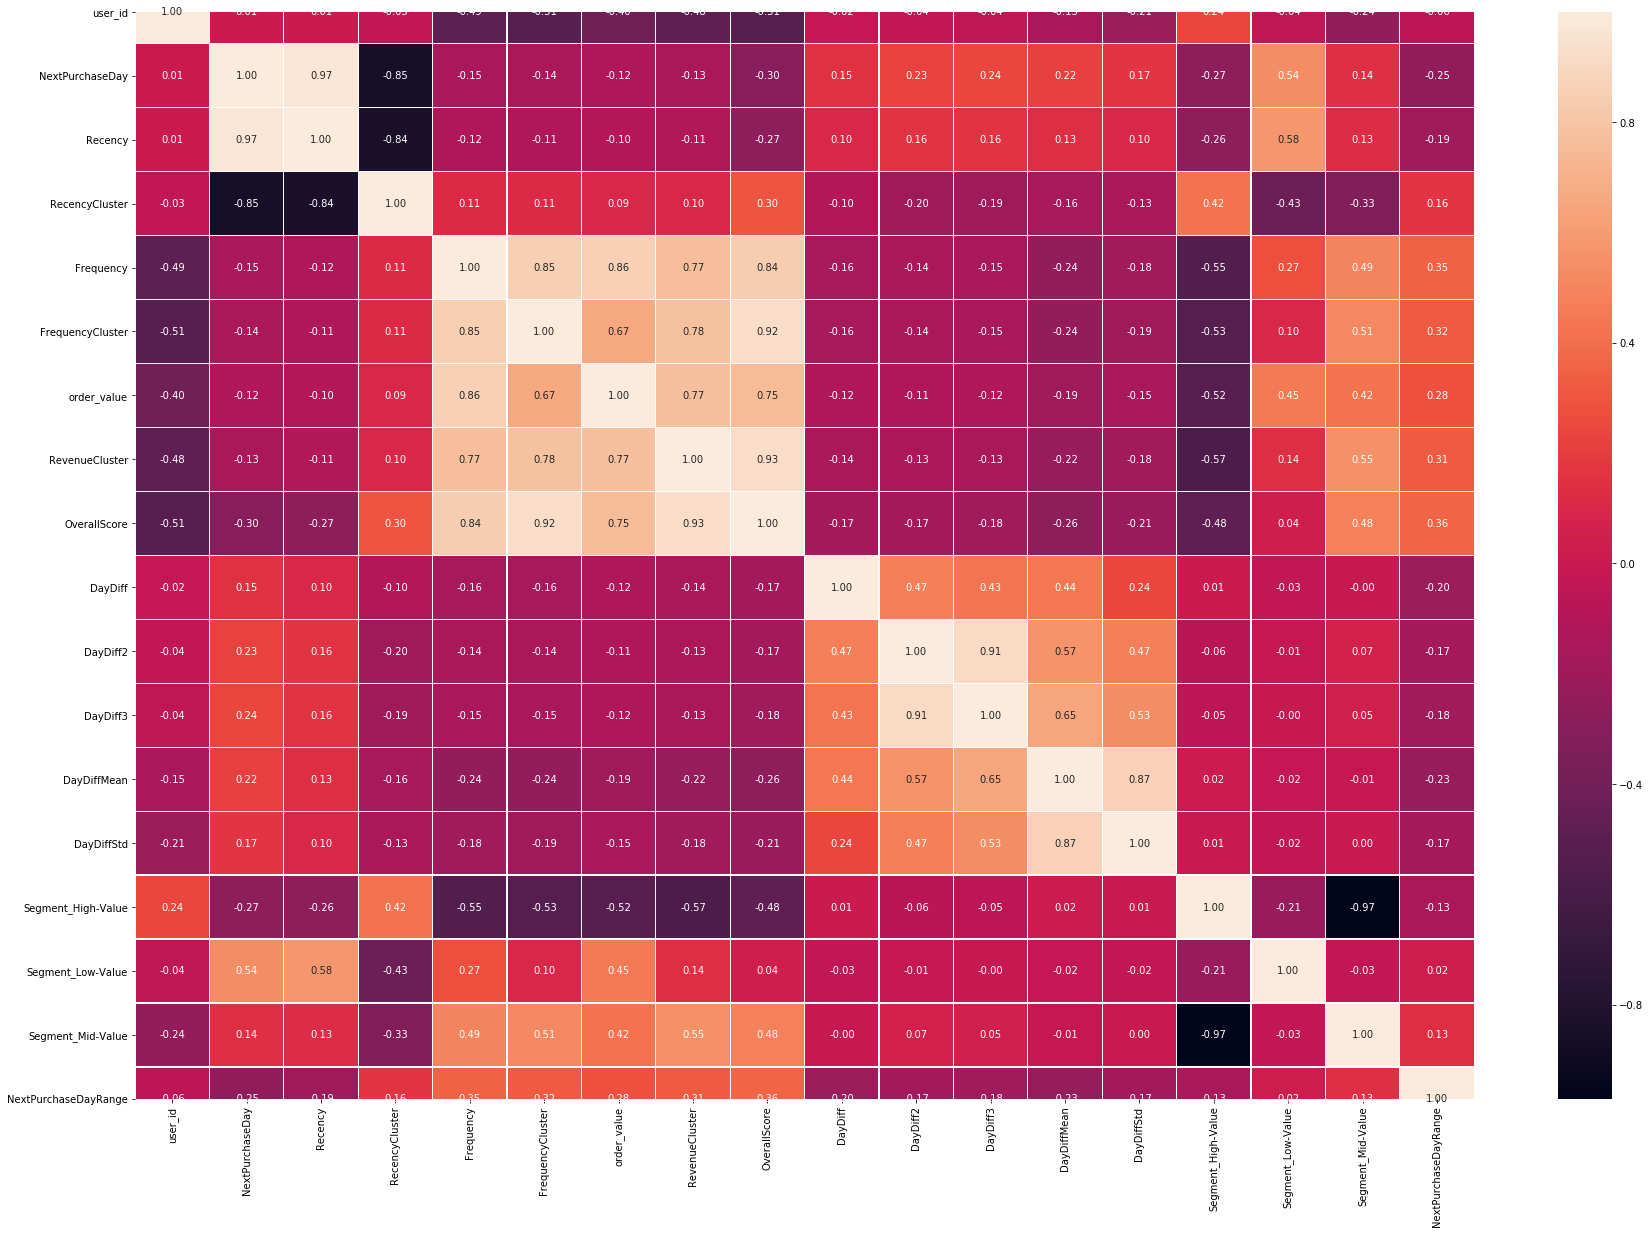

In [86]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [87]:
tx_class = tx_class.drop('NextPurchaseDay',axis=1)

In [88]:
len(tx_class)

1186

In [89]:
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

In [90]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [162]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=44)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.60240964 0.5686747 ]
NB [0.41204819 0.55180723]
RF [0.68192771 0.64819277]
SVC [0.48674699 0.4939759 ]
Dtree [0.60722892 0.66024096]
XGB [0.67951807 0.6746988 ]
KNN [0.48192771 0.50361446]


In [92]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.65


In [93]:
y_pred = xgb_model.predict(X_test)

In [94]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       184
           1       0.51      0.49      0.50       116
           2       0.52      0.55      0.53        56

    accuracy                           0.65       356
   macro avg       0.60      0.61      0.61       356
weighted avg       0.65      0.65      0.65       356



In [166]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(1,11,2),
 'min_child_weight':range(1,10,2),
 'n_estimators':range(50,800,10)   
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
            param_grid = param_test1, scoring='accuracy',n_jobs=None,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50},
 0.6879354793756968)

In [163]:
xgb_model = xgb.XGBClassifier(max_depth=5, min_child_weight=1, n_estimators=50).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.67


In [164]:
y_pred = xgb_model.predict(X_test)

In [165]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       184
           1       0.53      0.52      0.52       116
           2       0.54      0.54      0.54        56

    accuracy                           0.67       356
   macro avg       0.62      0.62      0.62       356
weighted avg       0.67      0.67      0.67       356

